In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd

In [3]:
def file_read(filename):
    """
    Reading LIDAR laser beams (x,y and z global coordinates of the scans)
    """
    points = np.array( pd.read_csv(filename) )

    poses = points[:,:3]
    measurements = points[:,3:]

    return poses, measurements

In [75]:
def convert2map(pose, points, map_pix, map_size, prob):
    """Converts list of XY points to 2D array map in which each pixel denotes
    probability of pixel being occupied.

    Parameters
    ----------
    pose : ndarray
        XY coordinates of the robot in the map reference frame
    points : ndarray
        List of XY points measured by sensor in the map reference frame
    map_pix : int
        Size of map pixel in m
    map_size : tuple
        Size of the map in pixels
    prob : float
        Probability


    Returns
    -------
    map : ndarray
        2D array representing map with dtype numpy.float32
    """
    zero = (pose//map_pix).astype(np.int32)
    pixels = (points//map_pix).astype(np.int32)
    mask = (pixels[:, 0] >= 0) & (pixels[:, 0] < map_size[0]) & \
           (pixels[:, 1] >= 0) & (pixels[:, 1] < map_size[1])
    pixels = pixels[mask]
    img = Image.new('L', (map_size[1], map_size[0]))
    draw = ImageDraw.Draw(img)
    zero = (zero[1], zero[0])
    for p in set([(q[1], q[0]) for q in pixels]):
        draw.line([zero, p], fill=1)
    data = -np.fromstring(img.tobytes(), np.int8).reshape(map_size)
    data[pixels[:, 0], pixels[:, 1]] = 1
    return 0.5 + prob*data.astype(np.float32)

In [21]:
filename = 'coordsXYZ1567005444.69.csv'
poses, scans = file_read(filename)

# remove points without movement
poses = poses[500:3200, :]
scans = scans[500:3200, :]

In [24]:
poses.shape

(2700, 3)

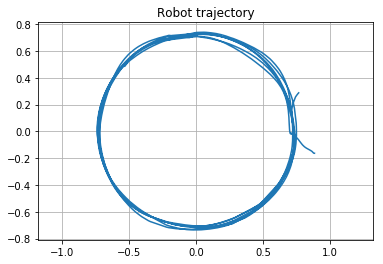

Starting poin: x0=1, y0=-0


In [28]:
robotX = poses[:,0]
robotY = poses[:,1]
robotZ = poses[:,2]

plt.plot(robotX,robotY)
plt.grid()
plt.title('Robot trajectory')
plt.axis("equal")
plt.show()

print('Starting poin: x0=%.0f'%robotX[0]+', y0=%0.f'%robotY[0])

In [92]:
# Clear occupancy grid
DIM_X = 4.0
DIM_Y = 4.0
RESOLUTION = 0.05

LOWEST_X = -2.0
LOWEST_Y = -2.0

grid = np.zeros((int(DIM_X / RESOLUTION), int(DIM_Y / RESOLUTION)))

In [29]:
scans.shape

(2700, 12)

In [93]:
# remove nan-values from scans array
scans_global = []
for i in range(poses.shape[0]):
    scan_x = np.array( [scans[i,0],
                        scans[i,3],
                        scans[i,6],
                        scans[i,9]
                        ] )
    scan_y = np.array( [scans[i,1],
                        scans[i,4],
                        scans[i,7],
                        scans[i,10]
                        ] )
    # remove nans:
    scan_x = [x for x in scan_x if str(x) != 'nan']
    scan_y = [y for y in scan_y if str(y) != 'nan']
    
    a = np.array(scan_x)[:,np.newaxis]
    b = np.array(scan_y)[:,np.newaxis]
    
    scans_global.append(np.hstack([a,b]))

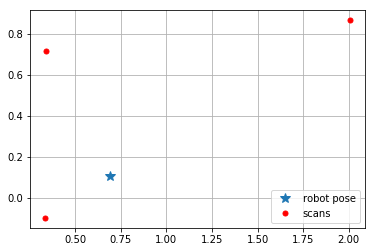

In [94]:
# Scans in global coordinate frame
time_i = 150
plt.plot(poses[time_i,0], poses[time_i,1], '*', markersize=10, label='robot pose')
plt.plot(scans_global[time_i][:,0], scans_global[time_i][:,1], 'ro', markersize=5, label='scans')
plt.legend()
plt.grid()

In [95]:
# Probabilities occupancy grids for each measurement
map_size = (int(DIM_X / RESOLUTION),int(DIM_Y / RESOLUTION) )
L = np.zeros(map_size)

for i in range(len(poses)):
    pose = poses[i] - np.array([LOWEST_X,LOWEST_Y,0])
    grid = convert2map( pose[:2], scans_global[i] - np.array([LOWEST_X,LOWEST_Y]), map_pix=RESOLUTION, map_size=map_size, prob=0.01 )
    # Converting of occupancy grid to log-odds representation
    l = np.log(grid/(1-grid))
    if i == 0:
        L = l
    else:
        L += l

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


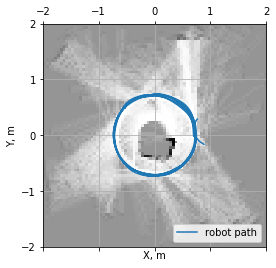

In [96]:
# Converting from the final log-odds representation to the probabilities grid
G = 1 / (1 + np.exp(-L))

plt.matshow(G.T, cmap= plt.cm.Greys,origin='lower',extent=[LOWEST_X, DIM_X+LOWEST_X, LOWEST_Y, DIM_Y+LOWEST_Y])
plt.grid()
plt.plot(robotX,robotY, label='robot path')
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.legend(loc=4)
plt.savefig('multiranger_map.png',dpi=300)
plt.show()